In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from numba import njit, jit, prange
sns.set_style("whitegrid")

In [2]:
a = 3
b = 2
alpha = a/b

S = 100

r_init = S*1 #int(S*0.35)
s_init = S*1 #int(S*0.5)
c_init = S*0 #int(S*0.5)

In [3]:
#fit_parameters = np.load(r'C:\Users\Rohit Vasav\Downloads\params_f_range.npz')
#k_off, k_u, k_b, j_off, J_on_hat, g_off = fit_parameters['params'][0,0]

## Parameters obtained from experimental data
k_off, k_u, k_b, j_off, J_on_hat, g_off = [3.9018766517549692, 1.9799379861044861, 6.615504603306438, 
                                           3.481669158554892, 3.016688368288114, 5.910017828840013]

G_on = J_on_hat/(1+j_off/g_off)
J_on = J_on_hat - G_on

K_on = k_off/(1+(k_b/k_u)*J_on_hat/(j_off+g_off)) - G_on + g_off*J_on_hat/(j_off+g_off)

## Theoretical steady state values
r_star = J_on_hat / (j_off + g_off)
s_star = (K_on + G_on -g_off*r_star) / k_off
c_star = k_b/k_u * r_star * s_star

## Scaling the parameters with S
J_on *= S
G_on *= S
k_b /= S
K_on *= S

r_star *= S
s_star *= S
c_star *= S

In [4]:
T_end = 13
dt = 1/20000

time_arr = np.arange(0,T_end,dt)
time_steps = len(time_arr)

num_trials = 2000

In [5]:
fluxes = np.array([J_on, G_on, k_u*c_star, g_off*r_star, j_off*r_star, k_b*r_star*s_star, K_on, k_off*s_star])

In [6]:
@njit(parallel=True)
def langevin_process(r_init, s_init, c_init, fluxes, num_trials, time_steps):
    
    r = np.zeros((num_trials,time_steps),dtype=np.float64)
    s = np.zeros((num_trials,time_steps),dtype=np.float64)
    c = np.zeros((num_trials,time_steps),dtype=np.float64)
    
    r[:,0], s[:,0], c[:,0] = r_init, s_init, c_init
    
    for trial in prange(num_trials):
        
        for t in prange(1,time_steps):

            rates = np.array([J_on, G_on, k_u*c[trial,t-1], g_off*r[trial,t-1], j_off*r[trial,t-1], 
                              k_b*r[trial,t-1]*s[trial,t-1], K_on, k_off*s[trial,t-1]],dtype = np.float64)
            
            xi = np.array([np.random.normal(0,np.sqrt(fluxes[i]/dt)) for i in range(8)],dtype=np.float64)

            r[trial,t] = r[trial,t-1] + dt*(  alpha*(rates[2] + xi[2]) 
                                - alpha*(rates[5] + xi[5])
                                - (rates[4] + xi[4])
                                - (rates[3] + xi[3])
                                + (rates[0] + xi[0])
                                + (rates[1] + xi[1]) )

            s[trial,t] = s[trial,t-1] + dt*(  (rates[2] + xi[2]) 
                                - (rates[5] + xi[5])
                                - (rates[7] + xi[7])
                                - (rates[3] + xi[3])
                                + (rates[6] + xi[6])
                                + (rates[1] + xi[1]) )

            c[trial,t] = c[trial,t-1] + dt*( -(rates[2] + xi[2]) + (rates[5] + xi[5]) )
            
    return r,s,c

In [7]:
r, s, c = langevin_process(r_init, s_init, c_init, fluxes, num_trials, time_steps)

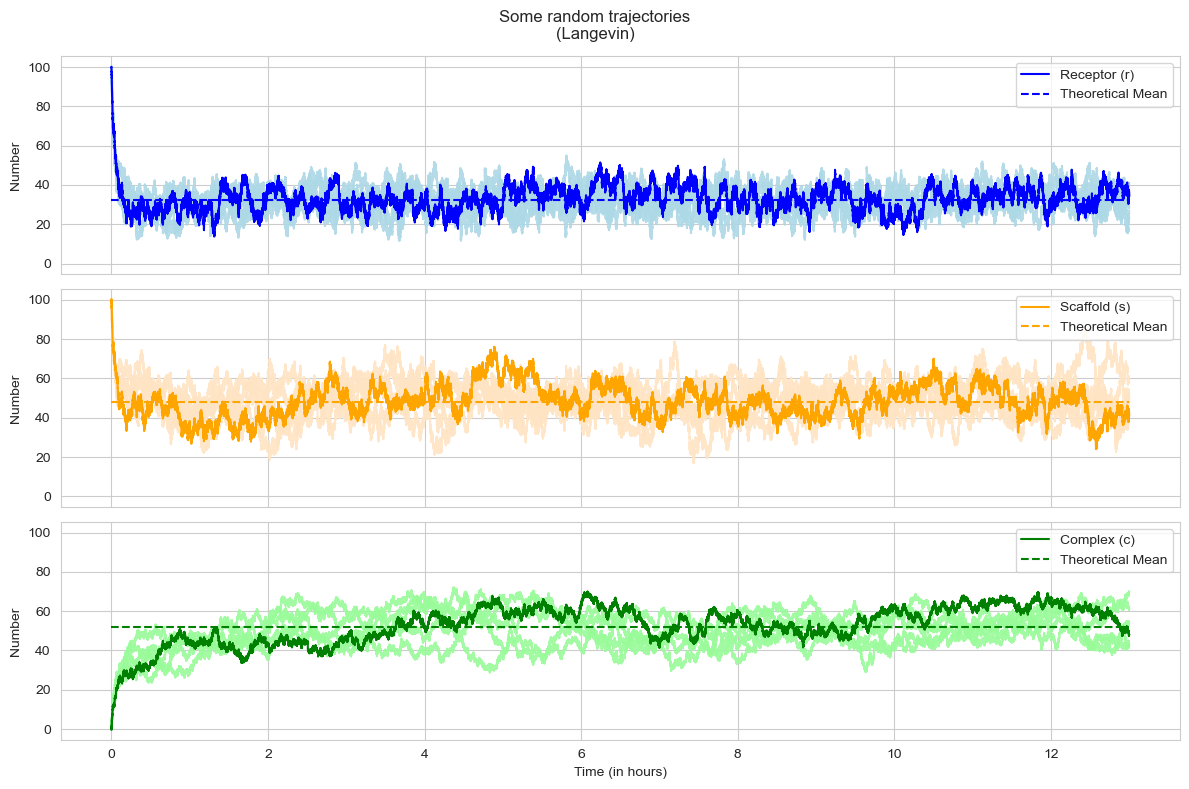

In [8]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

for i in np.random.randint(1,num_trials,5):
    axs[0].plot(time_arr,r[i,:],color='lightblue',alpha=0.9)
axs[0].plot(time_arr,r[0,:],color='blue',label = "Receptor (r)")
axs[0].hlines(r_star,xmin=0,xmax=T_end,color='blue',ls='--',lw=1.5,label="Theoretical Mean")
axs[0].set_ylabel("Number")
axs[0].legend(loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[1].plot(time_arr,s[i,:],color='bisque',alpha=0.9)
axs[1].plot(time_arr,s[0,:],color='orange',label="Scaffold (s)")
axs[1].hlines(s_star,xmin=0,xmax=T_end,color='orange',ls='--',lw=1.5,label="Theoretical Mean")
axs[1].set_ylabel("Number")
axs[1].legend(loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[2].plot(time_arr,c[i,:],color='palegreen',alpha=0.9)
axs[2].plot(time_arr,c[0,:],color='green',label="Complex (c)")
axs[2].hlines(c_star,xmin=0,xmax=T_end,color='green',ls='--',lw=1.5,label="Theoretical Mean")
axs[2].set_ylabel("Number")
axs[2].set_xlabel("Time (in hours)")
axs[2].legend(loc='upper right')

fig.suptitle('Some random trajectories\n(Langevin)')
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Some_random_trajectories_Langevin.png",dpi=100)
plt.show()

In [9]:
mean_r = np.mean(r,axis=0)
mean_s = np.mean(s,axis=0)
mean_c = np.mean(c,axis=0)

std_r = np.std(r,axis=0)
std_s = np.std(s,axis=0)
std_c = np.std(c,axis=0)

In [10]:
r_stat = r[:,time_steps//2:].flatten()
s_stat = s[:,time_steps//2:].flatten()
c_stat = c[:,time_steps//2:].flatten()

num_stat = r_stat.shape[0]

mu_r, sigma_r = np.mean(r_stat), np.std(r_stat)
mu_s, sigma_s = np.mean(s_stat), np.std(s_stat)
mu_c, sigma_c = np.mean(c_stat), np.std(c_stat)

print(num_stat)
print(mu_r, r_star, abs(mu_r-r_star)/r_star * 100,"% error")
print(mu_s, s_star, abs(mu_s-s_star)/s_star * 100,"% error")
print(mu_c, c_star, abs(mu_c-c_star)/c_star * 100,"% error")
print((mu_s + mu_c)/S, abs((mu_s + mu_c)/S - 1) * 100,"% error")

print(sigma_r,sigma_s,sigma_c)

260000000
32.15856600840967 32.120835930083445 0.11746294028073596 % error
48.13978215234023 48.23360340267108 0.19451428819778396 % error
51.962694312166086 51.766396597328914 0.379199109345194 % error
1.0010247646450632 0.10247646450631809 % error
5.932139080081684 8.451927027866965 8.071871062845736


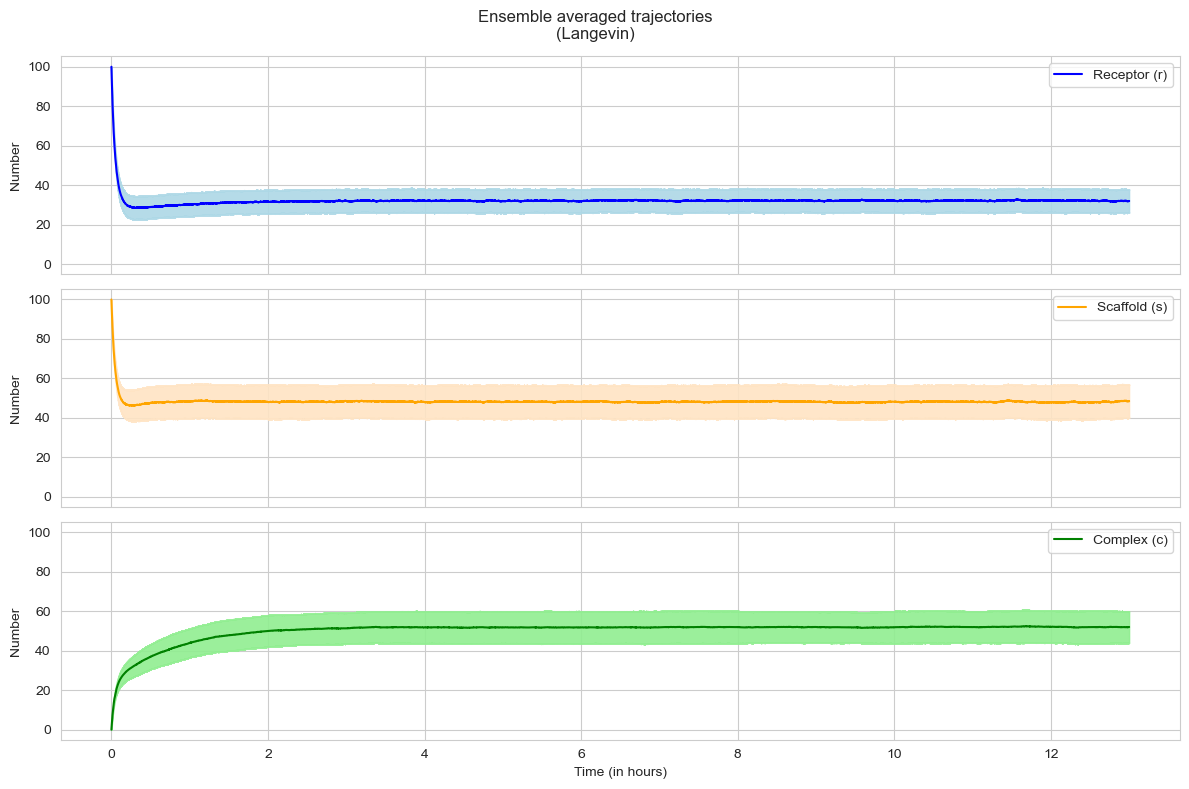

In [11]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

axs[0].fill_between(time_arr, mean_r-std_r, mean_r+std_r, color='lightblue',alpha=0.9)
axs[0].plot(time_arr,mean_r,color='blue',label = "Receptor (r)")
axs[0].set_ylabel("Number")
axs[0].legend()

axs[1].fill_between(time_arr, mean_s-std_s, mean_s+std_s, color='bisque',alpha=0.9)
axs[1].plot(time_arr,mean_s,color='orange',label="Scaffold (s)")
axs[1].set_ylabel("Number")
axs[1].legend()

axs[2].fill_between(time_arr, mean_c-std_c, mean_c+std_c, color='lightgreen',alpha=0.9)
axs[2].plot(time_arr,mean_c,color='green',label="Complex (c)")
axs[2].set_ylabel("Number")
axs[2].set_xlabel("Time (in hours)")
axs[2].legend(loc='upper right')

fig.suptitle('Ensemble averaged trajectories\n(Langevin)')
fig.tight_layout()
plt.show()

In [12]:
r_stat_sp = np.load('/users/nsr/rvasav/Internship/Data/r_stat.npy')
s_stat_sp = np.load('/users/nsr/rvasav/Internship/Data/s_stat.npy')
c_stat_sp = np.load('/users/nsr/rvasav/Internship/Data/c_stat.npy')

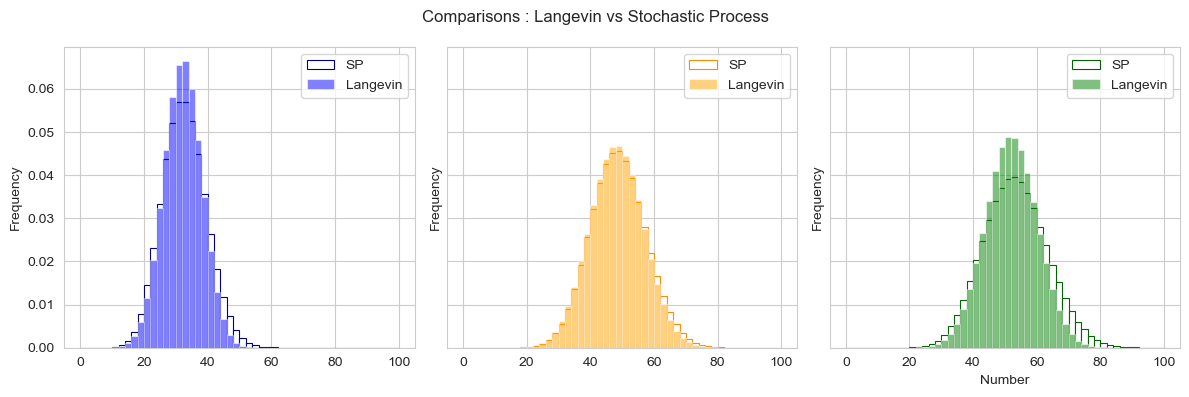

In [13]:
fig, axs = plt.subplots(1,3, figsize=(12,4),sharex=True, sharey=True)

axs[0].hist(r_stat_sp,bins=range(0,S+1,b),density=True,facecolor = 'white',edgecolor = 'darkblue',linewidth=0.8,label="SP")
axs[0].hist(r_stat,bins=range(0,S+1,b),density=True,facecolor = 'blue',edgecolor = 'white',linewidth=0.8,alpha=0.5,label="Langevin")
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(s_stat_sp,bins=range(0,S+1,b),density=True,facecolor = 'white',edgecolor = 'darkorange',linewidth=0.8,label="SP")
axs[1].hist(s_stat,bins=range(0,S+1,b),density=True,facecolor = 'orange',edgecolor = 'white',linewidth=0.8,alpha=0.5,label="Langevin")
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(c_stat_sp,bins=range(0,S+1,b),density=True,facecolor = 'white',edgecolor = 'darkgreen',linewidth=0.8,label="SP")
axs[2].hist(c_stat,bins=range(0,S+1,b),density=True,facecolor = 'green',edgecolor = 'white',linewidth=0.8,alpha=0.5,label="Langevin")
axs[2].set_xlabel("Number")
axs[2].set_ylabel('Frequency')
axs[2].legend(loc='upper right')

fig.suptitle('Comparisons : Langevin vs Stochastic Process')
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Comparisons_Langevin_vs_Stochastic_Process.png",dpi=100)
plt.show()

# Correlation Functions

In [14]:
@njit(parallel=True)
def correlation_function(data_a, data_b, num_trials, N_tau):
    
    cf_arr = np.zeros((num_trials,N_tau),dtype=np.float64)
    cf_arr[:,0] = np.sum(data_a*data_b,axis=1)/N_tau
    
    for trial in prange(num_trials):
        for l in prange(1,N_tau):
            tmp = np.sum(data_a[trial,l:][:N_tau-l]*data_b[trial,:-l][:N_tau-l])
            cf_arr[trial,l] = tmp / (N_tau-l)

    cf = np.sum(cf_arr, axis=0)/num_trials
    return cf

In [15]:
def pair_correlation_function(data_a, data_b, num_trials, N_tau):
    return np.concatenate( ( np.flip(correlation_function(data_b,data_a,num_trials,N_tau)[1:]),
                     correlation_function(data_a,data_b,num_trials,N_tau) ) )

## Autocorrelation Function

$$C_{xx}(\tau) = \langle\, \tilde{x}(t+\tau)\;\tilde{x}(t)\,\rangle \sim e^{-\tau/\tau_c}$$

where $\tilde{x} = \frac{x-\mu_x}{\sigma_x}$

In [ ]:
r_norm = (r[:,time_steps//2:]-r_star)/sigma_r
s_norm = (s[:,time_steps//2:]-s_star)/sigma_s
c_norm = (c[:,time_steps//2:]-c_star)/sigma_c

N_tau = r_norm.shape[1]
    
acf_r = correlation_function(r_norm, r_norm, num_trials, N_tau)
acf_s = correlation_function(s_norm, s_norm, num_trials, N_tau)
acf_c = correlation_function(c_norm, c_norm, num_trials, N_tau)

In [ ]:
mod_acf_r = acf_r[acf_r>=0.12]
mod_time_arr_r = time_arr[:len(mod_acf_r),np.newaxis]

a_r,_,_,_ = np.linalg.lstsq(mod_time_arr_r,np.log(mod_acf_r),rcond=None)
tau_c_r = -1/a_r

mod_acf_s = acf_s[acf_s>=0.08]
mod_time_arr_s = time_arr[:len(mod_acf_s),np.newaxis]

a_s,_,_,_ = np.linalg.lstsq(mod_time_arr_s,np.log(mod_acf_s),rcond=None)
tau_c_s = -1/a_s

mod_acf_c = acf_c[acf_c>=0.06]
mod_time_arr_c = time_arr[:len(mod_acf_c),np.newaxis]

a_c,_,_,_ = np.linalg.lstsq(mod_time_arr_c,np.log(mod_acf_c),rcond=None)
tau_c_c = -1/a_c

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(time_arr[:N_tau], acf_r,color='blue',label='r')
axs[0].plot(time_arr[:N_tau], acf_s,color='orange',label='s')
axs[0].plot(time_arr[:N_tau], acf_c,color='green',label='c')
axs[0].set_xlabel(r"$\tau$ (in hours)")
axs[0].set_ylabel(r"$A(\tau)$")
axs[0].legend()

axs[1].plot(time_arr[:N_tau],acf_r,color='blue')
axs[1].plot(mod_time_arr_r,np.exp(-mod_time_arr_r/tau_c_r),'--',label=r'$\tau_c(r)=$'+str((tau_c_r[0]*60).round(1))+" min")

axs[1].plot(time_arr[:N_tau],acf_s,color='orange')
axs[1].plot(mod_time_arr_s,np.exp(-mod_time_arr_s/tau_c_s),'--',label=r'$\tau_c(s)=$'+str((tau_c_s[0]*60).round(1))+" min")

axs[1].plot(time_arr[:N_tau],acf_c,color='green')
axs[1].plot(mod_time_arr_c,np.exp(-mod_time_arr_c/tau_c_c),'--',label=r'$\tau_c(c)=$'+str((tau_c_c[0]*60).round(1))+" min")

axs[1].set_yscale('log',base=10)
axs[1].set_xlabel(r"$\tau$ (in hours)")
axs[1].legend(loc='upper right')
axs[1].set_ylim(0.0008,1.2)
axs[1].set_xlim(-0.1,4.1)

fig.suptitle("Auto-Correlation Functions\n(Langevin)\n S = "+str(S))
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Auto_Correlation_Functions_Langevin(S = "+str(S)+").png",dpi=100)
plt.show()

## Pair Correlation Functions

$$C_{xy}(\tau) = \langle \,\tilde{x}(t+\tau)\;\tilde{y}(t)\, \rangle$$

where $\tilde{x} = \frac{x-\mu_x}{\sigma_x}$ and $\tilde{y} = \frac{y-\mu_y}{\sigma_y}$

In [ ]:
cf_rs = pair_correlation_function(r_norm, s_norm, num_trials, N_tau)
cf_sc = pair_correlation_function(s_norm, c_norm, num_trials, N_tau)
cf_rc = pair_correlation_function(r_norm, c_norm, num_trials, N_tau)

#cf_rs = pair_correlation_function(mod_r[:,bin_num//2:], mod_s[:,bin_num//2:], num_trials, N_tau)
#cf_sc = pair_correlation_function(mod_s[:,bin_num//2:], mod_c[:,bin_num//2:], num_trials, N_tau)
#cf_rc = pair_correlation_function(mod_r[:,bin_num//2:], mod_c[:,bin_num//2:], num_trials, N_tau)

tau_arr = np.concatenate((-np.flip(time_arr[1:N_tau]),time_arr[:N_tau]))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(tau_arr, cf_rs, label="$C_{rs}$")
axs[0].plot(tau_arr, cf_sc, label='$C_{sc}$')
axs[0].plot(tau_arr, cf_rc, label='$C_{rc}$')
axs[0].set_xlabel(r"$\tau$ (in hours)")
axs[0].set_ylabel(r"$C(\tau)$")
#axs[0].set_ylim(-0.17,0.3)
#axs[0].set_xlim(-0.3,0.3)
axs[0].legend()

axs[1].plot(tau_arr, cf_rs, label="$C_{rs}$")
axs[1].plot(tau_arr, cf_sc, label='$C_{sc}$')
axs[1].plot(tau_arr, cf_rc, label='$C_{rc}$')
axs[1].set_xlabel(r"$\tau$ (in hours)")
#axs[1].set_yscale('log',base=10)
axs[1].legend()
#axs[1].set_ylim(0.01,0.4)
axs[1].set_xlim(-1,1)

fig.suptitle("Correlation Functions\n(Langevin)\n S = "+str(S))
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Correlation_Functions_Langevin(S="+str(S)+").png",dpi=100)
plt.show()

# Matching with Experiments

To match the numerical observations with experimental data, we track two quantities,

$$R = r+\alpha c\qquad \& \qquad S = s+c$$

In [ ]:
mod_R = r + alpha*c
mod_S = s + c

mean_R = np.mean(mod_R,axis=0)
mean_S = np.mean(mod_S,axis=0)

std_R = np.std(mod_R,axis=0)
std_S = np.std(mod_S,axis=0)

In [ ]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)

axs[0].fill_between(time_arr, mean_R-std_R, mean_R+std_R, color='gainsboro',alpha=0.9)
axs[0].plot(time_arr,mean_R,color='black',label = "R")
axs[0].set_ylabel("Number")
axs[0].legend()

axs[1].fill_between(time_arr, mean_S-std_S, mean_S+std_S, color='mistyrose',alpha=0.9)
axs[1].plot(time_arr,mean_S,color='red',label="S")
axs[1].set_ylabel("Number")
axs[1].set_xlabel("Time (in hours)")
axs[1].legend(loc='upper right')

fig.suptitle('Ensemble average trajectories for experimental quantities\n(Langevin)')
fig.tight_layout()
plt.show()

## Experimental Correlation Functions

We have $\tilde{R}= \tilde{r} + \alpha \tilde{c}$ and $\tilde{S} = \tilde{s}+\tilde{c}$

$$ 
\begin{eqnarray}
A_{R}(\tau) &=& \langle \,\tilde{R}(t+\tau)\;\tilde{R}(t)\,\rangle = \langle \,\{\tilde{r}(t+\tau) + \alpha \tilde{c}(t+\tau)\}\;\{\tilde{r}(t) + \alpha \tilde{c}(t)\}\,\rangle \\
&=& \langle \,\tilde{r}(t+\tau) \;\tilde{r}(t) \,\rangle + \alpha^2\langle \,\tilde{c}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{r}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{r}(t) \,\rangle\\
&=& A_r(\tau) + \alpha^2 A_c(\tau) + \alpha C_{rc}(\tau) + \alpha C_{rc}(-\tau)
\end{eqnarray}
$$

Similarly, 

$$A_{S}(\tau)  = A_s(\tau) + A_c(\tau) + C_{sc}(\tau) + C_{sc}(-\tau)$$

Also,

$$ 
\begin{eqnarray}
C_{RS}(\tau) &=& \langle \,\tilde{R}(t+\tau)\;\tilde{S}(t)\,\rangle = \langle \,\{\tilde{r}(t+\tau) + \alpha \tilde{c}(t+\tau)\}\;\{\tilde{s}(t) + \tilde{c}(t)\}\,\rangle \\
&=& \langle \,\tilde{r}(t+\tau) \;\tilde{s}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{c}(t) \,\rangle + \langle \,\tilde{r}(t+\tau) \;\tilde{c}(t) \,\rangle + \alpha\langle \,\tilde{c}(t+\tau) \;\tilde{s}(t) \,\rangle\\
&=& C_{rs}(\tau) + \alpha A_c(\tau) +  C_{rc}(\tau) + \alpha C_{sc}(-\tau)
\end{eqnarray}
$$

In [ ]:
R_stat = mod_R[:,time_steps//2:].flatten()
S_stat = mod_S[:,time_steps//2:].flatten()

mu_R, sigma_R = np.mean(R_stat), np.std(R_stat)
mu_S, sigma_S = np.mean(S_stat), np.std(S_stat)

R_norm = (mod_R[:,time_steps//2:] - r_star - alpha*c_star)/sigma_R
S_norm = (mod_S[:,time_steps//2:] - s_star - c_star)/sigma_S

In [ ]:
acf_R = correlation_function(R_norm, R_norm, num_trials, N_tau)
acf_S = correlation_function(S_norm, S_norm, num_trials, N_tau)
cf_RS = pair_correlation_function(R_norm, S_norm, num_trials, N_tau)

In [ ]:
mod_acf_R = acf_R[acf_R>=0.05]
mod_time_arr_R = time_arr[:len(mod_acf_R),np.newaxis]

a_R,_,_,_ = np.linalg.lstsq(mod_time_arr_R,np.log(mod_acf_R),rcond=None)
tau_c_R = -1/a_R

mod_acf_S = acf_S[acf_S>=0.05]
mod_time_arr_S = time_arr[:len(mod_acf_S),np.newaxis]

a_S,_,_,_ = np.linalg.lstsq(mod_time_arr_S,np.log(mod_acf_S),rcond=None)
tau_c_S = -1/a_S

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(time_arr[:N_tau], acf_R,color='black',label='R')
axs[0].plot(time_arr[:N_tau], acf_S,color='red',label='S')
axs[0].set_xlabel(r"$\tau$ (in hours)")
axs[0].set_ylabel(r"$A(\tau)$")
axs[0].legend()

axs[1].plot(time_arr[:N_tau],acf_R,color='black')
axs[1].plot(mod_time_arr_R,np.exp(-mod_time_arr_R/tau_c_R),'--',color='black', label=r'$\tau_c(R)=$'+str((tau_c_R[0]*60).round(1))+" min")

axs[1].plot(time_arr[:N_tau],acf_S,color='red')
axs[1].plot(mod_time_arr_S,np.exp(-mod_time_arr_S/tau_c_S),'--',color='red', label=r'$\tau_c(S)=$'+str((tau_c_S[0]*60).round(1))+" min")
axs[1].set_yscale('log',base=10)
axs[1].set_xlabel(r"$\tau$ (in hours)")
axs[1].legend(loc='upper right')
axs[1].set_ylim(0.006,1.2)
axs[1].set_xlim(-0.1,3.1)

fig.suptitle("Auto-Correlation Functions\n(Langevin)\nS = "+str(S))
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Auto_Correlation_Functions_Experimental_Langevin(S="+str(S)+").png",dpi=100)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(tau_arr, cf_RS,color='darkslategray')
axs[0].set_xlabel(r"$\tau$ (in hours)")
axs[0].set_ylabel(r"$C_{RS}(\tau)$")
axs[0].set_ylim(-0.1,1.04)

axs[1].plot(tau_arr, cf_RS,color='darkslategray')
axs[1].set_xlabel(r"$\tau$ (in hours)")
axs[1].set_yscale('log',base=10)
axs[1].set_ylim(0.002,1.2)
axs[1].set_xlim(-4,4)

fig.suptitle("Correlation Function\n(Langevin)\nS = "+str(S))
fig.tight_layout()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Correlation_Function_Experimental_Langevin(S="+str(S)+").png",dpi=100)
plt.show()

# Theoretical Confirmation

In [ ]:
k_r = alpha*k_b*s_star + j_off + g_off 
K_s = k_b*s_star + g_off
k_s = k_b*r_star + k_off

In [ ]:
def H_s(w):
    return 1j*w + k_s - ((k_u*k_b*r_star)/(1j*w+k_u))

def H_r(w):
    return 1j*w + k_r - ((alpha*k_u*k_b*s_star)/(1j*w + k_u)) + (alpha*k_b*r_star*(1j*w/(1j*w+k_u))*(1/H_s(w))*(((k_u*k_b*s_star)/(1j*w + k_u)) - K_s))

def Gamma(w):
    return -alpha*k_b*r_star*(1j*w/(1j*w+k_u))*(1/H_s(w))
    
def Lambda(w):
    return alpha*k_u/(1j*w+k_u) - (alpha*k_b*r_star*(1j*w/(1j*w+k_u))*(1/H_s(w))*(k_u/(1j*w+k_u)))

def chichi(w):
    return 4*np.pi*(fluxes[2]*alpha**2 + fluxes[4] + fluxes[3]) + 4*np.pi*(fluxes[2]+fluxes[7]+fluxes[3])*np.abs(Gamma(w))**2 + 4*np.pi*fluxes[2]*np.abs(Lambda(w))**2 + (4*np.pi*(alpha*fluxes[2] + fluxes[3])*(Gamma(w)+np.conjugate(Gamma(w)))) - (4*np.pi*alpha*fluxes[2]*(Lambda(w)+np.conjugate(Lambda(w)))) - 4*np.pi*fluxes[2]*(np.conjugate(Gamma(w))*Lambda(w) + Gamma(w)*np.conjugate(Lambda(w)))

In [ ]:
pow_spec = np.zeros(N_tau//2+1,dtype=complex)

w_arr = 2*np.pi*np.arange(0,N_tau//2+1)/(dt*N_tau)

for i,w in enumerate(w_arr):
    pow_spec[i] = chichi(w)/np.abs(H_r(w))**2

In [ ]:
acf_r_sp = np.load('/users/nsr/rvasav/Internship/Data/acf_r.npy')
acf_s_sp = np.load('/users/nsr/rvasav/Internship/Data/acf_s.npy')
acf_c_sp = np.load('/users/nsr/rvasav/Internship/Data/acf_c.npy')

In [ ]:
plt.plot(w_arr,2*np.fft.rfft(acf_r*sigma_r**2)*dt,color='red', linewidth=1, label=r"$\hat{C}_{rr}(\omega)$ (Langevin)")
plt.plot(w_arr,2*dt*np.fft.rfft(acf_r_sp*sigma_r**2)[:len(w_arr)],color='black', linewidth = 1,label=r"$\hat{C}_{rr}(\omega)$ (Gillespie)")
plt.plot(w_arr,pow_spec/(2*np.pi),color='blue', linewidth= 1, label=r"$\langle|\hat{\delta}r(\omega)|^2\rangle$ (Theory)")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\omega$")
plt.title("Comparisons : Power Spectrum vs. Simulations\n(in Fourier space)")
plt.legend()
#plt.savefig("/users/nsr/rvasav/Internship/Graphs/Comparisons_Power_spectrum.png",dpi=100)
plt.show()